# Downloading and Unzipping Dataset

In [0]:
!wget https://zenodo.org/record/2538136/files/hirise-map-proj-v3.zip?download=1

--2019-06-04 18:11:19--  https://zenodo.org/record/2538136/files/hirise-map-proj-v3.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.184.65.20
Connecting to zenodo.org (zenodo.org)|188.184.65.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 985889206 (940M) [application/octet-stream]
Saving to: ‘hirise-map-proj-v3.zip?download=1’

hirise-map-proj-v3. 100%[===================>] 940.22M  24.5MB/s    in 45s     

2019-06-04 18:12:10 (20.8 MB/s) - ‘hirise-map-proj-v3.zip?download=1’ saved [985889206/985889206]



In [0]:
!mv hirise-map-proj-v3.zip\?download\=1 hirise.zip

In [0]:
!unzip -qq hirise.zip

In [0]:
!ls -l

total 969448
-rw-r--r-- 1 root root 985889206 May 25 09:07 hirise.zip
-rw-r--r-- 1 root root   2514353 Jan  9 21:58 labels-map-proj-v3.txt
-rw-r--r-- 1 root root        98 Jan  9 21:59 landmarks_map-proj-v3_classmap.csv
drwxrwxr-x 2 root root      4096 Jan 11 21:38 __MACOSX
drwxrwxr-x 2 root root   4288512 Jan  9 21:57 map-proj-v3
-rw-r--r-- 1 root root      1205 Jan 11 21:38 README.txt
drwxr-xr-x 1 root root      4096 May 31 16:17 sample_data


# Preliminary Analysis of CSV Files

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
labels_map = pd.read_csv('labels-map-proj-v3.txt', sep=' ', names=['image_name', 'label'])

In [0]:
labels_map.head()

,image_name,label
0,ESP_011623_2100_RED-0069.jpg,0
1,ESP_011623_2100_RED-0069-r90.jpg,0
2,ESP_011623_2100_RED-0069-r180.jpg,0
3,ESP_011623_2100_RED-0069-r270.jpg,0
4,ESP_011623_2100_RED-0069-fh.jpg,0


### Distribution of Samples

In [0]:
landmark_map = pd.read_csv('landmarks_map-proj-v3_classmap.csv', names=['label', 'landmark'])

In [0]:
landmark_map

,label,landmark
0,0,other
1,1,crater
2,2,dark dune
3,3,slope streak
4,4,bright dune
5,5,impact ejecta
6,6,swiss cheese
7,7,spider


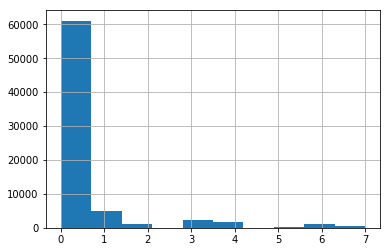

In [0]:
labels_map['label'].hist()

In [0]:
labels_map['landmark'].value_counts()

other            61054
crater            4900
slope streak      2331
bright dune       1750
swiss cheese      1148
dark dune         1141
spider             476
impact ejecta      231
Name: landmark, dtype: int64

# Python Data Generator

In [0]:
class DataProcessor:
    '''
    Takes care of creating batches of training and validation samples,
    using Python Generators
    '''

    def __init__(self, data_root, batch_size=128, test_size=0.2, included_labels=[0, 1, 2, 3, 4, 5, 6, 7]):
        '''
        Constructor that reads the data root folder and creates training and validation generators
        :param data_root: Root folder containing the labels map and a folder of recorded images from MRO
        :param batch_size: Batch size to be used while generating samples
        :param test_size: Train-Test Split to be used while generating samples
        :param included_labels: List of all labels to be included in the provided output
        '''

        self.data_root = data_root
        self.batch_size = batch_size
        self.test_size = test_size
        self.labels_map = pd.read_csv(data_root + 'labels-map-proj-v3.txt', sep=' ', names=['image_name', 'label'])
        self.labels_map = self.labels_map[self.labels_map['label'].isin(included_labels)]
        self.train_samples, self.validation_samples = self.init_samples()
        self.train_generator = self.generator(self.train_samples, self.batch_size)
        self.validation_generator = self.generator(self.validation_samples, self.batch_size)

    def init_samples(self):
        '''
        Uses an 80%, 20% split of the dataset into training and validation sets
        :return: Tuple with training and validation samples
        '''

        self.samples = self.labels_map[['image_name', 'label']].values

        return train_test_split(self.samples, test_size=self.test_size)

    def generator(self, samples, batch_size):
        '''
        Creates a Generator function that will be used by the model during training. This improves performance by loading
        only images by a batch of the given batch size into memory
        :param samples: List of samples
        :param batch_size: The size of the sample list required at one time
        :return: Shuffled tuple of sample features and labels
        '''

        num_samples = len(samples)
        while 1:  # Loop forever so the generator never terminates
            shuffled_samples = sklearn.utils.shuffle(samples)
            for offset in range(0, num_samples, batch_size):
                batch_samples = shuffled_samples[offset:offset + batch_size]

                images = []
                labels = []
                for batch_sample in batch_samples:
                    # print("Batch=", batch_sample)
                    name = self.data_root + 'map-proj-v3/' + batch_sample[0].strip()
                    image = mpimg.imread(name)
                    label = batch_sample[1]

                    ## TODO: Uncomment if flip augmentation is required
                    # is_flip_required = np.random.choice([True, False], p=[0.1, 0.9])
                    # if is_flip_required:
                    #    image = np.fliplr(image)

                    images.append(image)
                    labels.append(label)

                # trim image to only see section with road
                X_train = np.array(images)
                y_train = np.array(labels)
                yield sklearn.utils.shuffle(X_train, y_train)

    def get_train_generator(self):
        return self.train_generator

    def get_validation_generator(self):
        return self.validation_generator

    def get_batch_size(self):
        return self.batch_size

    def get_training_steps_per_epoch(self):
        return int(len(self.train_samples) / self.batch_size)

    def get_validation_steps(self):
        return int(len(self.validation_samples) / self.batch_size)

In [0]:
## Use the included_labels parameter to include labels/landmarks of interest
data_processor = DataProcessor('./', batch_size=32, test_size=0.2, included_labels=[0, 1, 2, 3, 4, 5, 6, 7])

## Initializing training and validation generators

In [0]:
train_generator = data_processor.get_train_generator()
validation_generator = data_processor.get_validation_generator()

In [0]:
batch_images, batch_labels = next(train_generator)

In [0]:
batch_images.shape, batch_labels.shape

((32, 227, 227), (32,))

In [0]:
batch_images, batch_labels = next(validation_generator)

In [0]:
batch_images.shape, batch_labels.shape

((32, 227, 227), (32,))

## Mapping function from Label to Landmark name

In [0]:
def get_landmark(label):
  return landmark_map[landmark_map['label'] == label]['landmark'].iloc[0]

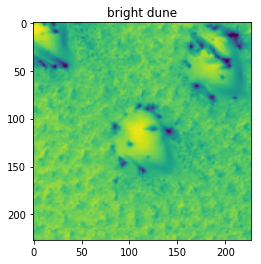

In [0]:
plt.title(get_landmark(batch_labels[5]))
plt.imshow(batch_images[5])